# 1. Import

In [1]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
from os.path import basename, dirname, join


import glob
import argparse
import datetime
import random
import json
from netCDF4 import Dataset
import numpy as np

import data_generator
from data_generator import HugoDataGenerator, DataGenerator_sod_f, HugoBinaryGenerator

import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.metrics import (confusion_matrix, 
                            mean_squared_error, 
                            accuracy_score,
                            precision_score,
                            recall_score)
from scipy import stats

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2

# idir = '/Data/preprocessing4hugo/output/'
input_dir_json = '/Data/'
idir = '/tf/data/hugo_continous/output_preprocessed_continous/output/'

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-oa3rshbw because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# 2. Definition model

In [3]:
def create_model():
    """ Create sequential CNN with convolutional and dense layers for the continous network
    
    """
    # number of ice classes
    nbr_classes = 4  
    # size of SAR subimages
    ws = 50
    # size of convolutional filters
    cs = 3
    # number of filters per convolutional layer (x id)
    c1,c2,c3 = 32,32,32
    # number of neurons per hidden neural layer number (x id)
    n1,n2,n3 = 16,16,64
    # value of dropout
    dropout_rate = 0.1
    # value of L2 regularisation
    l2_rate = 0.001

    model = Sequential()

    # Convolutional part
    model.add(BatchNormalization(input_shape=(ws, ws, 2)))
    model.add(Conv2D(c1, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(Conv2D(c2, (cs, cs), activation='relu'))
    model.add(Conv2D(c3, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(BatchNormalization())

    model.add(Flatten())

    # Neural network part (hidden layers)
    model.add(Dropout(dropout_rate))
    model.add(Dense(n1, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n2, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n3, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))

    # Last neural layer (not hidden)
    model.add(Dense(nbr_classes, kernel_regularizer=l2(l2_rate), activation='softmax'))
    
    return model

# 3. Load Data

### 3.1 Parameters and load files

In [4]:
train_ratio = 0.7
with open(f'{idir}processed_files.json') as fichier_json:
    all_nc = json.load(fichier_json)
npz_files=[]

for nc in all_nc :
    name = nc[:15]
    files = sorted(glob.glob(f'{idir}/{name}/*.npz'))
    npz_files += files
random.shuffle(npz_files)

npz_files = npz_files[:10000]

print('Files number : '+ str (len(npz_files)))
train_files_number = int(len(npz_files) * train_ratio)
train_files = npz_files[:train_files_number]
valid_files = npz_files[train_files_number:]

input_var_names = ['nersc_sar_primary', 'nersc_sar_secondary']
amsr2_var_names = [ 'btemp_6_9h',
                    'btemp_6_9v',
                    'btemp_7_3h',
                    'btemp_7_3v',
                    'btemp_10_7h',
                    'btemp_10_7v',
                    'btemp_18_7h',
                    'btemp_18_7v',
                    'btemp_23_8h',
                    'btemp_23_8v',
                    'btemp_36_5h',
                    'btemp_36_5v',
                    'btemp_89_0h',
                    'btemp_89_0v'
                  ]
 
output_var_name = 'ice_type'
dims_amsr2 = np.load(npz_files[0])[amsr2_var_names[0]].shape

params = {'dims_amsr2':      (*dims_amsr2, len(amsr2_var_names)),
          'idir_json':       input_dir_json,
          'output_var_name': output_var_name,
          'input_var_names': input_var_names,
          'amsr2_var_names': amsr2_var_names,
          'batch_size':      50,
          'shuffle_on_epoch_end': False,
           }

Files number : 10000


### 3.2 processed data for model

In [5]:
# training_generator2 = HugoBinaryGenerator(train_files, **params)
# validation_generator2 = HugoBinaryGenerator(valid_files, **params)

training_generator = HugoDataGenerator(train_files, **params)
validation_generator = HugoDataGenerator(valid_files, **params)

# training_generator = DataGenerator_sod_f(train_files, **params)
# validation_generator = DataGenerator_sod_f(valid_files, **params)

print(
     training_generator[0][0].shape, #sar
#      training_generator[0][0][1].shape, #amsr2
     training_generator[0][1].shape, #output
)

(50, 50, 50, 2) (50, 4)


# 4. Load model and trained weights

### 4.1 Load model and trained weights

In [6]:
# creation of the model 
model = create_model()


### 4.2 Apply CNN to SAR data

In [7]:
#callbacks
mc = tf.keras.callbacks.ModelCheckpoint(filepath='hugo_model_1000', 
                                        monitor='val_loss',
                                        verbose=1, 
                                        save_best_only=True,
                                        mode='min')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#optimizers and compile
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')

#fit
model.summary()
history = model.fit(training_generator, 
                    use_multiprocessing=True,
                    workers=4,
                    validation_data=validation_generator,
                    epochs=20, 
                    callbacks=[mc, es])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 50, 50, 2)        8         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0

INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 9s 50ms/step - loss: 0.1216 - val_loss: 0.2308
Epoch 2/20
140/140 [==============================] - ETA: 0s - loss: 0.0889
Epoch 2: val_loss improved from 0.23079 to 0.12964, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 49ms/step - loss: 0.0889 - val_loss: 0.1296
Epoch 3/20
139/140 [============================>.] - ETA: 0s - loss: 0.0744
Epoch 3: val_loss improved from 0.12964 to 0.06816, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 6s 45ms/step - loss: 0.0744 - val_loss: 0.0682
Epoch 4/20
140/140 [==============================] - ETA: 0s - loss: 0.0664
Epoch 4: val_loss improved from 0.06816 to 0.06102, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 46ms/step - loss: 0.0664 - val_loss: 0.0610
Epoch 5/20
140/140 [==============================] - ETA: 0s - loss: 0.0621
Epoch 5: val_loss improved from 0.06102 to 0.06056, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 45ms/step - loss: 0.0621 - val_loss: 0.0606
Epoch 6/20
140/140 [==============================] - ETA: 0s - loss: 0.0595
Epoch 6: val_loss improved from 0.06056 to 0.05551, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 46ms/step - loss: 0.0595 - val_loss: 0.0555
Epoch 7/20
140/140 [==============================] - ETA: 0s - loss: 0.0574
Epoch 7: val_loss improved from 0.05551 to 0.05287, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 45ms/step - loss: 0.0574 - val_loss: 0.0529
Epoch 8/20
138/140 [============================>.] - ETA: 0s - loss: 0.0560
Epoch 8: val_loss did not improve from 0.05287
140/140 [==============================] - 5s 33ms/step - loss: 0.0560 - val_loss: 0.0536
Epoch 9/20
140/140 [==============================] - ETA: 0s - loss: 0.0549
Epoch 9: val_loss improved from 0.05287 to 0.05165, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 47ms/step - loss: 0.0549 - val_loss: 0.0516
Epoch 10/20
139/140 [============================>.] - ETA: 0s - loss: 0.0532
Epoch 10: val_loss improved from 0.05165 to 0.05071, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 47ms/step - loss: 0.0531 - val_loss: 0.0507
Epoch 11/20
139/140 [============================>.] - ETA: 0s - loss: 0.0534
Epoch 11: val_loss improved from 0.05071 to 0.05058, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 46ms/step - loss: 0.0534 - val_loss: 0.0506
Epoch 12/20
140/140 [==============================] - ETA: 0s - loss: 0.0529
Epoch 12: val_loss improved from 0.05058 to 0.04964, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 46ms/step - loss: 0.0529 - val_loss: 0.0496
Epoch 13/20
140/140 [==============================] - ETA: 0s - loss: 0.0521
Epoch 13: val_loss improved from 0.04964 to 0.04954, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 48ms/step - loss: 0.0521 - val_loss: 0.0495
Epoch 14/20
140/140 [==============================] - ETA: 0s - loss: 0.0518
Epoch 14: val_loss did not improve from 0.04954
140/140 [==============================] - 5s 33ms/step - loss: 0.0518 - val_loss: 0.0498
Epoch 15/20
138/140 [============================>.] - ETA: 0s - loss: 0.0508
Epoch 15: val_loss improved from 0.04954 to 0.04806, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 45ms/step - loss: 0.0508 - val_loss: 0.0481
Epoch 16/20
139/140 [============================>.] - ETA: 0s - loss: 0.0511
Epoch 16: val_loss did not improve from 0.04806
140/140 [==============================] - 5s 33ms/step - loss: 0.0511 - val_loss: 0.0488
Epoch 17/20
139/140 [============================>.] - ETA: 0s - loss: 0.0506
Epoch 17: val_loss did not improve from 0.04806
140/140 [==============================] - 5s 34ms/step - loss: 0.0505 - val_loss: 0.0486
Epoch 18/20
140/140 [==============================] - ETA: 0s - loss: 0.0505
Epoch 18: val_loss improved from 0.04806 to 0.04805, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 7s 47ms/step - loss: 0.0505 - val_loss: 0.0481
Epoch 19/20
140/140 [==============================] - ETA: 0s - loss: 0.0503
Epoch 19: val_loss did not improve from 0.04805
140/140 [==============================] - 5s 34ms/step - loss: 0.0503 - val_loss: 0.0485
Epoch 20/20
138/140 [============================>.] - ETA: 0s - loss: 0.0497
Epoch 20: val_loss did not improve from 0.04805
140/140 [==============================] - 5s 34ms/step - loss: 0.0498 - val_loss: 0.0486


### 4.3 History of loss

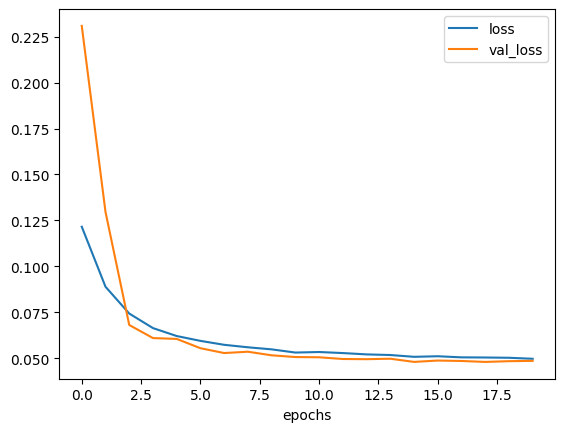

In [8]:
plt.clf()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

### 4.4 Metrics

In [9]:
y_pred = model.predict(validation_generator)
y_val = np.vstack([vg[1] for vg in validation_generator])

60/60 [==============================] - 5s 83ms/step
[[0.10899025 0.19814806 0.61216176 0.08069988]
 [0.91645694 0.0067635  0.06533867 0.01144093]
 [0.06096594 0.27017346 0.6213716  0.04748901]
 ...
 [0.85772634 0.01066902 0.11222529 0.01937936]
 [0.90823996 0.00530231 0.07644852 0.01000912]
 [0.8962097  0.0067227  0.08466103 0.01240658]]
[[0.  0.4 0.6 0. ]
 [1.  0.  0.  0. ]
 [0.2 0.  0.8 0. ]
 ...
 [1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [1.  0.  0.  0. ]]


#### Pearson and rmse matrices

rmse_matrix
[[0.06560467 0.30851392 0.33633389 0.29756579]
 [0.35685605 0.02049735 0.14086987 0.05459792]
 [0.34215686 0.11996166 0.05848412 0.10467732]
 [0.35869683 0.04482148 0.1310932  0.02596673]]
pearson_matrix
[[ 0.79590634 -0.35706851 -0.60483316 -0.40811556]
 [-0.59459058  0.54173929  0.49021428  0.0347012 ]
 [-0.74600653  0.37108331  0.62881635  0.26487741]
 [-0.60319368  0.02587706  0.33461181  0.67891402]]
(6000, 6000)


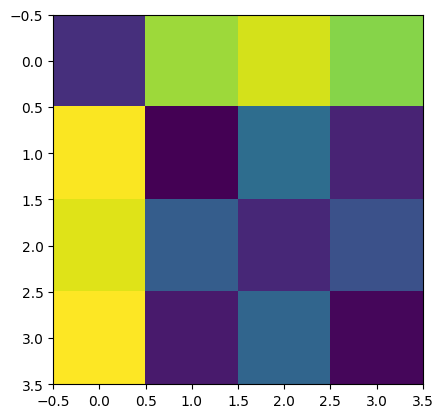

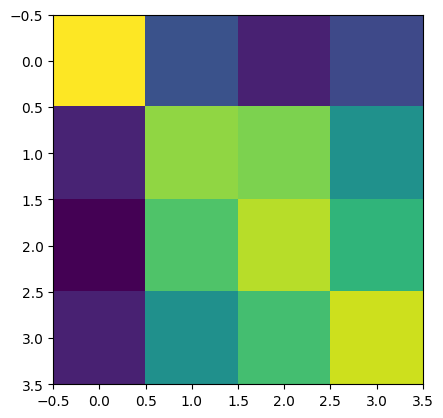

In [23]:
rmse_matrix=np.empty((4,4))
pearson_matrix = np.empty((4,4))
for id_class_pred in range(y_pred.shape[1]):
    classes_pred = y_pred[:,id_class_pred]
    for id_class_val in range (y_val.shape[1]):
        classes_val = y_val[:,id_class_val]
        rmse = mean_squared_error(classes_val, classes_pred)
        rmse_matrix[id_class_pred][id_class_val] = rmse
        pearson_value = stats.pearsonr(classes_val, classes_pred)
        pearson_matrix[id_class_pred][id_class_val] = pearson_value[0]

print('rmse_matrix')
print(rmse_matrix)
print('pearson_matrix')
print(pearson_matrix)

plt.imshow(rmse_matrix)
plt.show()
plt.imshow(pearson_matrix)
plt.show()